```
# Copyright 2022 by the author(s) of CHI2023 submission "Short-Form
# Videos Degrade Our Capacity to Retain Intentions: Effect of Context
# Switching On Prospective Memory". All rights reserved.
#
# Use of this source code is governed by a GPLv3 license that
# can be found in the LICENSE file.
```

In [4]:
import warnings
warnings.filterwarnings("ignore")

import random, string
from typing import List
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
import tensorflow as tf
import tensorflow_probability as tfp

from pyddm import Sample, Model, Fittable
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, LossRobustBIC
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'

from stats import fit_ex_gaussian

In [5]:
df_rt = pd.read_csv('data/rt.csv')

In [6]:
def fit_ddm(df: pd.DataFrame, rt_column_name: str, correct_column_name: str, show=False) -> List[float]:
    samples = Sample.from_pandas_dataframe(df, rt_column_name=rt_column_name, correct_column_name=correct_column_name)
    m = Model(name='ddm',
        drift=DriftConstant(drift=Fittable(minval=0, maxval=50)),
        noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
        bound=BoundConstant(B=Fittable(minval=.1, maxval=2)),
        overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
        dx=.001, dt=.0001, T_dur=3,
    )
    fit_adjust_model(samples, m, fitting_method="differential_evolution", lossfunction=LossRobustBIC, verbose=False)
    if show:
        pyddm.plot.plot_fit_diagnostics(model=m, sample=samples)
        display_model(m)
    # drift, noise, bound, nondecisiontime
    return [p.default() for p in m.get_model_parameters()]

def brownian_motion(N, T, h):
    """
    Simulates a Brownian motion
    :param int N : the number of discrete steps
    :param int T: the number of continuous time steps
    :param float h: the variance of the increments
    """
    dt = 1. * T/N                                                      # the normalizing constant
    random_increments = np.random.normal(0.0, 1.0 * h, N)*np.sqrt(dt)  # the epsilon values
    brownian_motion = np.cumsum(random_increments)                     # calculate the brownian motion
    brownian_motion = np.insert(brownian_motion, 0, 0.0)               # insert the initial condition
    return brownian_motion

def drifted_brownian_motion(mu, sigma, bound, T, N=500):
    """Simulates a Brownian Motion with drift.
    :param float mu: drift coefficient
    :param float sigma: volatility coefficient
    :param int T: number of continuous time steps
    :param int N : number of discrete steps
    :returns list: drifted Brownian motion
    """
    while True:
        W = brownian_motion(N, T, 1.0)
        time_steps = np.linspace(0.0, N*(1. * T/N), N+1) # generate the time steps
        Y = mu * time_steps + sigma * W                  # calculate the Brownian Motion with drift
        # find the first vaule bigger than bound
        indices = np.where(abs(Y) >= bound)
        if len(indices[0]) > 0:
            break
    return time_steps[:indices[0][0]], Y[:indices[0][0]]

In [7]:
def plot_diffusion(ax1, ax2, ax3, drift, noise, bound, non_decision_time, ground_truth, color_simulate='steelblue', color_true='red'):
    colors = sns.color_palette('vlag', as_cmap=False, n_colors=10)
    c1 = colors[0]
    c2 = colors[-1]
    color_simulate = c1
    color_true = c2

    Tmax = 3

    # configure x limit
    ax1.set_xlim(0, Tmax)
    ax2.set_xlim(0, Tmax)
    ax3.set_xlim(0, Tmax)

    # draw ground truth
    rts_true = ground_truth[ground_truth.correct == True].rt
    ax1.hist(rts_true, bins=50, color=color_simulate, alpha=.25)
    rts_false = ground_truth[ground_truth.correct == False].rt
    ax3.hist(rts_false, bins=50, color=color_true, alpha=.25)
    correct_grountruth = np.array([t==True for t in ground_truth.correct.values])
    ax1.text(.99, .9,  f'accuracy: {correct_grountruth.mean()*100:.2f}\%',  ha='right', va='top',    transform=ax1.transAxes, fontsize=8)
    ax3.text(.99, .05, f'error: {100 - correct_grountruth.mean()*100:.2f}\%', ha='right', va='bottom', transform=ax3.transAxes, fontsize=8)

    # make sure top and bottom distributions have the same y-axis scale.
    y1max = ax1.get_ylim()[1]
    y3max = ax3.get_ylim()[1]
    ymax = max(y1max,y3max)
    ax1.set(ylim=(0, ymax))
    ax3.set(ylim=(0, ymax))
    ax3.invert_yaxis()

    # setup DDM bound
    ax2.set(ylim=(-bound, bound))

    # simulate DDM
    trials = [drifted_brownian_motion(drift, noise, bound, Tmax) for _ in range(200)]
    correct = np.array([t[-1] > 0 for _, t in trials])

    hist_correct = []
    hist_error   = []
    upDrawed = False
    downDrawed = False
    for i, v in enumerate(correct):
        x, y = trials[i]
        if v:
            draw = y > -bound/4
            if False not in draw:
                ax2.plot(non_decision_time+x, y, alpha=.15, c=color_simulate, zorder=0, lw=0.3)
                if 0.5 < x[-1] < 1 and not upDrawed:
                    ax2.plot(non_decision_time+x, y, alpha=1, c=color_simulate, lw=1)
                    upDrawed = True
            hist_correct.append(x[-1])
        else:
            draw = y < bound/4
            if False not in draw:
                ax2.plot(non_decision_time+x, y, alpha=.15, c=color_true, zorder=0, lw=0.3)
                if 0.5 < x[-1] < 1 and not downDrawed:
                    ax2.plot(non_decision_time+x, y, alpha=1, c=color_true, lw=1)
                    downDrawed = True
            hist_error.append(x[-1])

    # Draw correct key press distribution.
    # Fit ex-gaussian until the error is below 1%
    corrects = non_decision_time+np.array(hist_correct)
    for _ in range(10):
        loc, scale, rate = fit_ex_gaussian(corrects, progress=True)
        y_pred = np.random.exponential(scale=1/rate, size=100) + np.random.normal(loc=loc, scale=scale, size=100)
        r = ks_2samp(corrects, y_pred)
        if r.pvalue >= 0.5:
            break
    p_y = tfp.distributions.ExponentiallyModifiedGaussian(loc=loc, scale=scale, rate=rate)
    x_t = np.linspace(0, Tmax, 500)
    y_line = p_y.prob(x_t)
    ax1.plot(x_t, y_line * y1max/2, label="y_estimate", color='steelblue')

    # Same here.
    errors   = non_decision_time+np.array(hist_error)
    for _ in range(10):
        try:
            loc, scale, rate = fit_ex_gaussian(errors, progress=True)
            y_pred = np.random.exponential(scale=1/rate, size=100) + np.random.normal(loc=loc, scale=scale, size=100)
            r = ks_2samp(corrects, y_pred)
            if r.pvalue >= 0.5:
                break
        except:
            pass
    p_y = tfp.distributions.ExponentiallyModifiedGaussian(loc=loc, scale=scale, rate=rate)
    x_t = np.linspace(0, Tmax, 500)
    y_line = p_y.prob(x_t)
    ax3.plot(x_t, y_line * y3max/2, label="y_estimate", color=color_true)

    # Draw non-decision time and decision bound.
    ax2.axhline(y=bound, xmin=0, xmax=3, c='black', lw=1, linestyle='--')
    ax2.axhline(y=0, xmin=0, xmax=non_decision_time/3, c='black', lw=1, linestyle='--') # why this has to divide by 3?
    ax2.axhline(y=-bound, xmin=0, xmax=3, c='black', lw=1, linestyle='--')
    ax2.text(2.98, bound-0.3,  f'decision upper bound $B={bound:.2f}$',  ha='right', va='top', fontsize=8)
    ax2.text(2.98, -bound+0.5, f'decision lower bound $B={-bound:.2f}$',  ha='right', va='top', fontsize=8)
    ax2.text(0.02, -0.3, f'non-decision\ntime~$t={non_decision_time*1000:.0f}$ms', ha='left', va='bottom', fontsize=8)

    ax2.text(0.02, -bound+0.25, f'drift~~$\mu={drift:.2f}$\n variance~$\sigma={noise:.2f}$', ha='left', va='bottom', c='black', fontsize=8)

    # Draw simulated distribution
    ax1.hist(corrects, bins=50, color=color_simulate)
    ax3.hist(errors, bins=50, color=color_true)

    # annotate axes labels.
    ax3.set_xticks(ax3.get_xticks().tolist())
    ax3.set_xticklabels([f'{x*1000:.0f}' for x in ax3.get_xticks()])
    ax2.set_yticks(ax2.get_yticks().tolist())
    ax2.set_yticklabels([f'{x:.0f}' for x in ax2.get_yticks()])

    ax1.set(ylabel='Counts')
    ax2.set(ylabel='Decision Process')
    ax3.set(xlabel='RTs (ms)', ylabel='Counts')

In [8]:
def fit_and_draw_ddm(task, interrupt, interruptName, measure, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    ddm_data = df_rt[(df_rt.task == task) & (df_rt.success == True) & (df_rt.interrupt == interrupt) & (df_rt.measure == measure)]
    print('fitting:', task, interrupt, measure)
    params = fit_ddm(ddm_data, 'rt', 'correct', show=False)
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, gridspec_kw={'height_ratios': (.25, .5, .25)})
    plot_diffusion(ax1, ax2, ax3, params[0], params[1], params[2], params[3], ddm_data)
    ax1.set_title(f'Fitted DDM for {interruptName} {string.capwords(measure)}-interruption RTs')
    f = f'figures/fig6_ddm_{task}_{interrupt}_{measure}_{seed}.pdf'
    print('saving to: ', f)
    plt.savefig(f, dpi=300, bbox_inches='tight')
    plt.cla()

fitting: PM tiktok pre


Info: Params [1.46260285 1.88944687 1.93592873 0.46076796] gave 457.12785448071037


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

2022-11-30 19:45:55.455686: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17b3ae1f0>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17b3ae1f0>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17f0dc9d0>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17f0dc9d0>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17fd2a820>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17fd2a820>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x298e1d280>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x298e1d280>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
saving to:  figures/ddm_PM_tiktok_pre_42.pdf
fitting: PM tiktok post


Info: Params [0.         2.34798562 1.71167503 0.68069025] gave 461.4626110965323


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x299bb8670>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x299bb8670>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17e389c10>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x17e389c10>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x29982d3a0>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function fit_ex_gaussian.<locals>.<lambda> at 0x29982d3a0>: no matching AST found among candidates:
# coding=utf-8
lambda y, distr: -distr.log_prob(y)
# coding=utf-8
lambda t: tfp.distributions.ExponentiallyModifiedGaussian(loc=t[..., :1], scale=0.001 + tf.math.softplus(0.05 * t[..., 1:]), rate=tf.math.softplus(t[..., 2:]))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
saving to:  figures/ddm_PM_tiktok_post_42.pdf


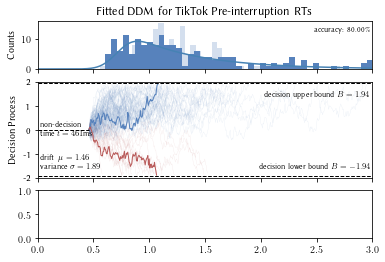

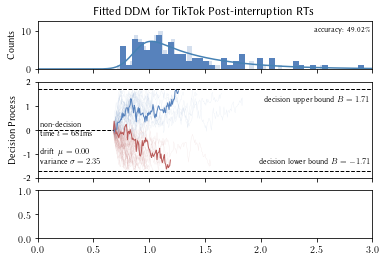

In [9]:
seed = 42
task = 'PM'

fit_and_draw_ddm('PM', 'tiktok', 'TikTok', 'pre', seed)
fit_and_draw_ddm('PM', 'tiktok', 'TikTok', 'post', seed)

# fit_and_draw_ddm('PM', 'twitter', 'Twitter', 'pre', seed)
# fit_and_draw_ddm('PM', 'twitter', 'Twitter', 'post', seed)

# fit_and_draw_ddm('PM', 'youtube', 'YouTube', 'pre', seed)
# fit_and_draw_ddm('PM', 'youtube', 'YouTube', 'post', seed)

# fit_and_draw_ddm('PM', 'rest', 'Rest', 'pre', seed)
# fit_and_draw_ddm('PM', 'rest', 'Rest', 'post', seed)